Существует 3 наиболее распространённые библитеки python для работы с файлами формата SEGY:

1. [segypy](https://pypi.org/project/segpy/) ([документация](https://segpy.readthedocs.io/en/latest/))
2. [segyio](https://pypi.org/project/segyio/) ([документация](https://segyio.readthedocs.io/en/latest/))
3. [ObsPy](https://docs.obspy.org/) ([документация](https://docs.obspy.org/tutorial/index.html))

ObsPy позволяет работать с разными форматами сейсмических данных, в том числе и с SEGY, поэтому отдадим предпочтение ей.

## 1. Создание файла формата SEGY

In [84]:
from obspy import read, Trace, Stream, UTCDateTime
from obspy.core import AttribDict
from obspy.io.segy.segy import SEGYTraceHeader, SEGYBinaryFileHeader
from obspy.io.segy.core import _read_segy
import numpy as np
import sys
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML 

[Trase](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.html) - Объект, содержащий данные непрерывного ряда, например сейсмический след

[Stream](https://docs.obspy.org/packages/autogen/obspy.core.stream.html#module-obspy.core.stream) - Модуль для обработки объектов ObsPy Stream

[UTCDateTime](https://docs.obspy.org/packages/autogen/obspy.core.utcdatetime.html#module-obspy.core.utcdatetime) - Модуль, содержащий класс datetime на основе UTC 

[AttribDict](https://docs.obspy.org/packages/autogen/obspy.core.util.attribdict.html#module-obspy.core.util.attribdict)

[SEGYTraceHeader](https://docs.obspy.org/packages/autogen/obspy.io.segy.segy.SEGYTraceHeader.html) - Класс, отвечающий за чтение и запись заголовков трассировки

[SEGYBinaryFileHeader](https://docs.obspy.org/packages/autogen/obspy.io.segy.segy.SEGYBinaryFileHeader.html) - Анализирует заголовок двоичного файла в заданной начальной позиции

[_read_segy](https://docs.obspy.org/packages/autogen/obspy.io.segy.core._read_segy.html) - Считывает файл SEG Y и возвращает объект ObsPy Stream

### 1.1 Создание произвольных данных

In [85]:
stream = Stream()
num_trace=10

for _i in range(num_trace):                        ##Цикл вызывается каждый раз при создании новой трассы
    data = np.random.ranf(1000)                    ## Массив случайных значений заданной формы
    data = np.require(data, dtype=np.float32)
    trace = Trace(data=data)
    trace.stats.delta = 0.01                       ## Атрибут trace.stats будет переписывать все в trace.stats.segy.trace_header
                                                   ## SEGY не поддерживает точность сотых долей секунды, они будут отброшены
    trace.stats.starttime = UTCDateTime(2011,11,11,11,11,11)   ## Всемирное координированное время (UTC)

 # Если вы хотите установить некоторые дополнительные атрибуты в заголовке трассировки,
 # добавьте один и установите только те атрибуты, которые вы хотите установить. В противном случае ... 
 # заголовок будет создан для вас со значениями по умолчанию.
    if not hasattr(trace.stats, 'segy.trace_header'):     ## Возвращает флаг, указывающий на то, содержит ли объект указанный атрибут hasattr(obj, name) -> bool
         trace.stats.segy = {}                            ## Словарь/набор
    trace.stats.segy.trace_header = SEGYTraceHeader()
    trace.stats.segy.trace_header.trace_sequence_number_within_line = _i + 1
    trace.stats.segy.trace_header.receiver_group_elevation = 500

 # Добавить трассу в stream
    stream.append(trace)

При необходимости объетку stream можно задать заголовки, все незаполненные заголовки будут заполненны автоматически.

In [86]:
stream.stats = AttribDict()
stream.stats.textual_file_header = 'Textual Header!'
stream.stats.binary_file_header = SEGYBinaryFileHeader()
stream.stats.binary_file_header.trace_sorting_code = 5

print ("Объект stream перед записью...", '\n', stream)

Объект stream перед записью... 
 10 Trace(s) in Stream:
Seq. No. in line:    1 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    2 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    3 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    4 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    5 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    6 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    7 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    8 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    9 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.99000

### 1.2 Запись в файл

In [87]:
stream.write("TEST.sgy", format="SEGY", data_encoding=1, byteorder=sys.byteorder)

## 2. Чтение из файла SEGY

Оценим скорость выполнения двух разных способов "чтения" из файла 

In [88]:
%%time
print ("Чтение с помощью obspy.io.segy...")
st1 = _read_segy("TEST.sgy")
print (st1)

Чтение с помощью obspy.io.segy...
10 Trace(s) in Stream:
Seq. No. in line:    1 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    2 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    3 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    4 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    5 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    6 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    7 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    8 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    9 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.9900

In [89]:
%%time
print ("Чтение с помощью obspy.core...")
st2 = read("TEST.sgy")
print (st2)

Чтение с помощью obspy.core...
10 Trace(s) in Stream:
Seq. No. in line:    1 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    2 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    3 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    4 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    5 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    6 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    7 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    8 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z | 100.0 Hz, 1000 samples
Seq. No. in line:    9 | 2011-11-11T11:11:11.000000Z - 2011-11-11T11:11:20.990000Z

In [90]:
print ("Демонстрация того, что значения записаны...", '\n',
    'receiver_group_elevation в переменной stream до записи: ', [tr.stats.segy.trace_header.receiver_group_elevation for tr in stream], '\n',
    'receiver_group_elevation из прочитанного файла: ', [tr.stats.segy.trace_header.receiver_group_elevation for tr in st2], '\n',
    'trace_sorting_code в переменной stream до записи: ', stream.stats.binary_file_header.trace_sorting_code, '\n',
    'trace_sorting_code из прочитанного файла: ', st1.stats.binary_file_header.trace_sorting_code, sep='')

Демонстрация того, что значения записаны...
receiver_group_elevation в переменной stream до записи: [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]
receiver_group_elevation из прочитанного файла: [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]
trace_sorting_code в переменной stream до записи: 5
trace_sorting_code из прочитанного файла: 5


### 2.1 Получаем массив с данными в NumPy для визуализации

Каждый след в st1.traces получает свой data, а затем отправляет данные в np.stack который складывает их в массив.

In [91]:
data1 = np.stack(t.data for t in st1.traces)   

Выводем размер двумерного массива

In [92]:
print(data1.shape, '\n',
    'Количество трасс: ', data1.shape[0], '\n',
     'Количество элементов в каждой трассе (?): ', data1.shape[1], sep='')

(10, 1000)
Количество трасс: 10
Количество элементов в каждой трассе (?): 1000


### 2.2 Отображение одной трассы

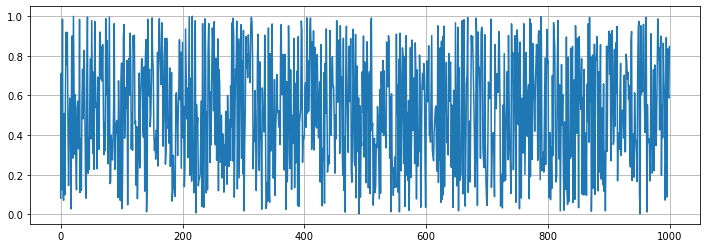

In [93]:
trace5 = st1.traces[5]

plt.figure(figsize=(12, 4))
plt.plot(trace5.data)
plt.grid(True)
plt.show()

### 2.3 Отображение всего потока

[np.procentile](https://pyprog.pro/statistics_functions/percentile.html)

In [94]:
vm = np.percentile(data1, 100)      
print("100 процентов амплитуды {:.0f}; максимальная амплитуда {:.0f}".format(vm, data.max()))

100 процентов амплитуды 1; максимальная амплитуда 1


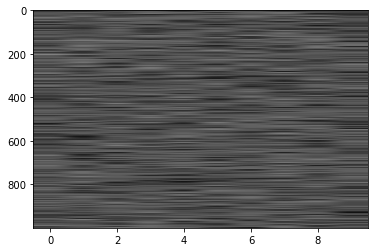

In [95]:
plt.imshow(data1.T, cmap="Greys", vmin=-vm, vmax=vm, aspect='auto')

### 2.4 Выведем заголовки 

Заголовок всего файла

In [96]:
from obspy.io.segy.segy import _read_segy

stream_TEST = _read_segy('TEST.SGY', headonly=True)

stream_TEST.binary_file_header

Binary File Header:
	job_identification_number: 0
	line_number: 0
	reel_number: 0
	number_of_data_traces_per_ensemble: 10
	number_of_auxiliary_traces_per_ensemble: 0
	sample_interval_in_microseconds: 10000
	sample_interval_in_microseconds_of_original_field_recording: 0
	number_of_samples_per_data_trace: 1000
	number_of_samples_per_data_trace_for_original_field_recording: 0
	data_sample_format_code: 1
	ensemble_fold: 0
	trace_sorting_code: 5
	vertical_sum_code: 0
	sweep_frequency_at_start: 0
	sweep_frequency_at_end: 0
	sweep_length: 0
	sweep_type_code: 0
	trace_number_of_sweep_channel: 0
	sweep_trace_taper_length_in_ms_at_start: 0
	sweep_trace_taper_length_in_ms_at_end: 0
	taper_type: 0
	correlated_data_traces: 0
	binary_gain_recovered: 0
	amplitude_recovery_method: 0
	measurement_system: 0
	impulse_signal_polarity: 0
	vibratory_polarity_code: 0
	unassigned_1: b'0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

Заголовок одной трассы

In [97]:
stream_TEST.traces[0].header

trace_sequence_number_within_line: 1
trace_sequence_number_within_segy_file: 0
original_field_record_number: 0
trace_number_within_the_original_field_record: 0
energy_source_point_number: 0
ensemble_number: 0
trace_number_within_the_ensemble: 0
trace_identification_code: 0
number_of_vertically_summed_traces_yielding_this_trace: 0
number_of_horizontally_stacked_traces_yielding_this_trace: 0
data_use: 0
distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group: 0
receiver_group_elevation: 500
surface_elevation_at_source: 0
source_depth_below_surface: 0
datum_elevation_at_receiver_group: 0
datum_elevation_at_source: 0
water_depth_at_source: 0
water_depth_at_group: 0
scalar_to_be_applied_to_all_elevations_and_depths: 0
scalar_to_be_applied_to_all_coordinates: 0
source_coordinate_x: 0
source_coordinate_y: 0
group_coordinate_x: 0
group_coordinate_y: 0
coordinate_units: 0
weathering_velocity: 0
subweathering_velocity: 0
uphole_time_at_source_in_ms: 0
uphole_time_at_group_in

## 3. SEGY файл из открытых ресурсов

Испльзуем файл формата SEGY из открытого источника [National Petroleum Reserve-Alaska Data Archive](https://certmapper.cr.usgs.gov/data/apps/npra/)

In [98]:
st_open = _read_segy("3X_75_PR.sgy")

In [99]:
st_open

1592 traces in the SEG Y structure.

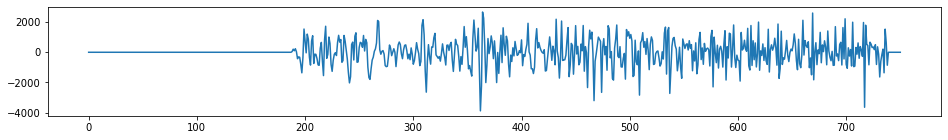

In [100]:
trace_test = st_open.traces[0]

plt.figure(figsize=(16,2))
plt.plot(trace_test.data)
plt.show()

In [101]:
Data = np.stack(t.data for t in st_open.traces)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [102]:
Data.shape

(1592, 751)

In [103]:
from IPython.html.widgets import interact

In [104]:
def pr (x):
    vm_test = np.percentile(Data, x)
    print("The {:.0f} percentile is {:.0f}; the max amplitude is {:.0f}".format(x, vm_test, Data.max()))

    plt.figure(figsize=(12,6))
    plt.imshow(Data.T, cmap="Greys", vmin= -vm_test, vmax=vm_test, aspect='auto')


i = interact (pr, x =(50,100))


#vm_test = np.percentile(Data, 90)
#print("The 90th percentile is {:.0f}; the max amplitude is {:.0f}".format(vm_test, Data.max()))

#plt.figure(figsize=(12,6))
#plt.imshow(Data.T, cmap="Greys", vmin= -vm_test, vmax=vm_test, aspect='auto')

interactive(children=(IntSlider(value=75, description='x', min=50), Output()), _dom_classes=('widget-interact'…

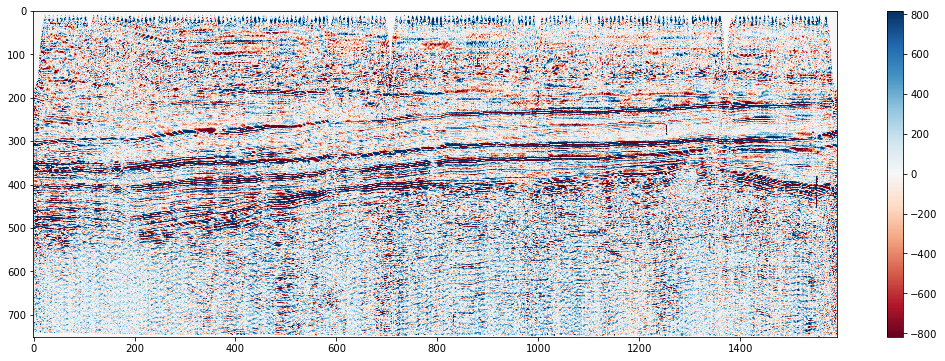

In [105]:
plt.figure(figsize=(18,6))
plt.imshow(Data.T, cmap="RdBu", vmin=-vm_test, vmax=vm_test, aspect='auto')
plt.colorbar()
plt.show()

In [106]:
from obspy.io.segy.segy import _read_segy

stream_header = _read_segy('3X_75_PR.SGY', headonly=True)

In [107]:
print(stream_header.binary_file_header)

Binary File Header:
	job_identification_number: 1110580000
	line_number: 3
	reel_number: 1110579969
	number_of_data_traces_per_ensemble: 1
	number_of_auxiliary_traces_per_ensemble: 0
	sample_interval_in_microseconds: 8000
	sample_interval_in_microseconds_of_original_field_recording: 0
	number_of_samples_per_data_trace: 751
	number_of_samples_per_data_trace_for_original_field_recording: 0
	data_sample_format_code: 1
	ensemble_fold: 1
	trace_sorting_code: 4
	vertical_sum_code: 1
	sweep_frequency_at_start: 0
	sweep_frequency_at_end: 0
	sweep_length: 0
	sweep_type_code: 0
	trace_number_of_sweep_channel: 0
	sweep_trace_taper_length_in_ms_at_start: 0
	sweep_trace_taper_length_in_ms_at_end: 0
	taper_type: 0
	correlated_data_traces: 0
	binary_gain_recovered: 1
	amplitude_recovery_method: 4
	measurement_system: 0
	impulse_signal_polarity: 0
	vibratory_polarity_code: 0
	unassigned_1: b'\xff\xfe\x00\x0c\x00\x01\x00\x00\x17p\x00\x01\x00\x01\x00\x08\x0c\x80\x00\x80\x00\x00\x00\x9b\x00\x02\x00\x9f\x

In [108]:
print(stream_header.traces[5].header)

trace_sequence_number_within_line: 6
trace_sequence_number_within_segy_file: 6
original_field_record_number: 11
trace_number_within_the_original_field_record: 0
energy_source_point_number: 0
ensemble_number: 6
trace_number_within_the_ensemble: 1
trace_identification_code: 1
number_of_vertically_summed_traces_yielding_this_trace: 1
number_of_horizontally_stacked_traces_yielding_this_trace: 1
data_use: 1
distance_from_center_of_the_source_point_to_the_center_of_the_receiver_group: 0
receiver_group_elevation: 0
surface_elevation_at_source: 0
source_depth_below_surface: 0
datum_elevation_at_receiver_group: 0
datum_elevation_at_source: 0
water_depth_at_source: 0
water_depth_at_group: 0
scalar_to_be_applied_to_all_elevations_and_depths: 0
scalar_to_be_applied_to_all_coordinates: 1
source_coordinate_x: 0
source_coordinate_y: 0
group_coordinate_x: 0
group_coordinate_y: 0
coordinate_units: 0
weathering_velocity: 0
subweathering_velocity: 0
uphole_time_at_source_in_ms: 0
uphole_time_at_group_in_

### В итоге получили:
1. Сгенерированный файл TEST.sgy
2. Визуализирован segy-файл из открытых источников (имеем представление как должен выглядеть файл после прочтения SU)
3. Получили заголовки файла и заголовки трасс